# Importing neccessary Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import seaborn as sns 

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image as Img_show
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_path =  '/kaggle/input/fer2013/train'
categories = ['angry', 'disgust', 'fear', 'happy', 'Neutral', 'Sad', 'Suprise']

# Reading Image

Training_52322132.jpg


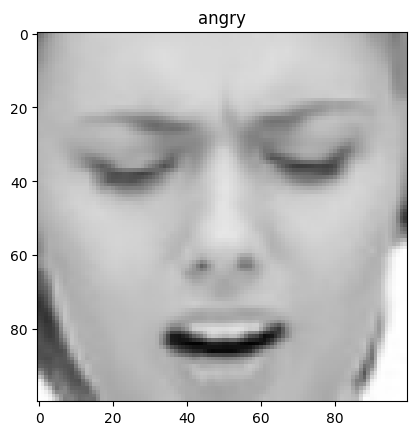

In [3]:
for emotion in categories:
  img_fol = os.path.join(data_path, emotion)
  for img_path in os.listdir(img_fol):
      img = cv2.imread(os.path.join(img_fol, img_path))
      img_resize = cv2.resize(img, (100, 100))
      plt.imshow(img_resize)
      plt.title(emotion)
      print(img_path)
      plt.plot()
      break
  break

# Creating DataGens

In [4]:
Train_Datagen = ImageDataGenerator(
    dtype = 'float32',
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    )

Test_Datagen = ImageDataGenerator(
    dtype = 'float32',
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    )

In [5]:
train_dataset  = Train_Datagen.flow_from_directory(directory = '/kaggle/input/fer2013/train',
                                                   target_size = (48, 48),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

Found 28709 images belonging to 7 classes.


In [6]:
test_dataset = Test_Datagen.flow_from_directory(directory = '/kaggle/input/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


# Building Model

In [7]:
# Resnet
base_model = tf.keras.applications.resnet.ResNet101(
    input_shape=(48,48,3),
    include_top=False,
    pooling='max',
    weights="imagenet")

171446536/171446536 [==============================] - 5s 0us/step


In [8]:
for layer in base_model.layers[:-50]:
    layer.trainable=False

In [9]:
# model=Sequential()
# model.add(base_model)

# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(128, kernel_initializer='RandomUniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(64, kernel_initializer='RandomUniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(32, kernel_initializer='RandomUniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dense(7,activation='softmax'))

In [10]:
model=Sequential()

model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 gaussian_noise (GaussianNo  (None, 2048)              0         
 ise)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1

In [12]:
# plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
# Img_show(filename='convnet.png')

In [13]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001, 
    beta_1=0.9, 
    beta_2=0.999, 
    epsilon=1e-08)

In [14]:
early_stopping = EarlyStopping(monitor = 'val_loss', verbose=1, patience=5, restore_best_weights=True)

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Training Model

In [16]:
history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = 60,
                  verbose = 1,
                  callbacks=[early_stopping])

Epoch 1/60
449/449 [==============================] - 247s 496ms/step - loss: 2.4680 - accuracy: 0.3421 - val_loss: 2.1636 - val_accuracy: 0.4234
Epoch 2/60
449/449 [==============================] - 58s 129ms/step - loss: 1.9424 - accuracy: 0.4329 - val_loss: 1.8280 - val_accuracy: 0.4706
Epoch 3/60
449/449 [==============================] - 60s 133ms/step - loss: 1.6970 - accuracy: 0.4653 - val_loss: 1.6005 - val_accuracy: 0.4622
Epoch 4/60
449/449 [==============================] - 57s 128ms/step - loss: 1.5527 - accuracy: 0.4864 - val_loss: 1.4958 - val_accuracy: 0.4866
Epoch 5/60
449/449 [==============================] - 60s 134ms/step - loss: 1.4598 - accuracy: 0.5099 - val_loss: 1.4049 - val_accuracy: 0.5033
Epoch 6/60
449/449 [==============================] - 62s 137ms/step - loss: 1.4054 - accuracy: 0.5222 - val_loss: 1.3448 - val_accuracy: 0.5343
Epoch 7/60
449/449 [==============================] - 58s 130ms/step - loss: 1.3595 - accuracy: 0.5366 - val_loss: 1.3411 - val_a

# Visualizing

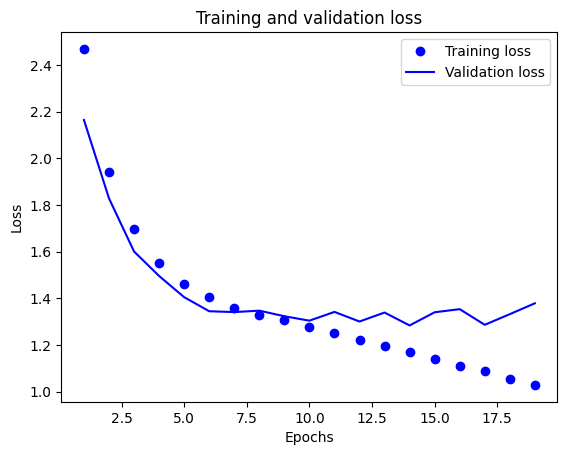

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

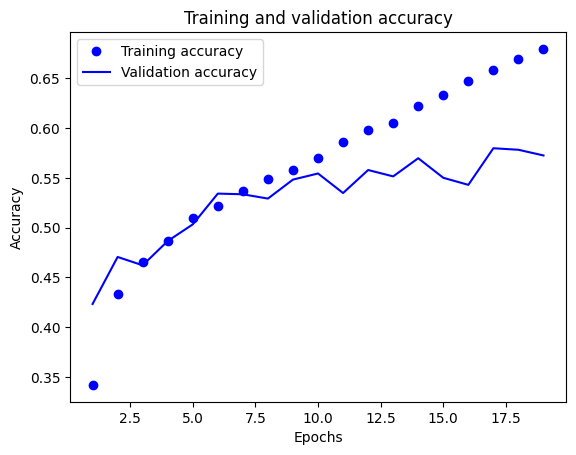

In [18]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

113/113 [==============================] - 9s 62ms/step


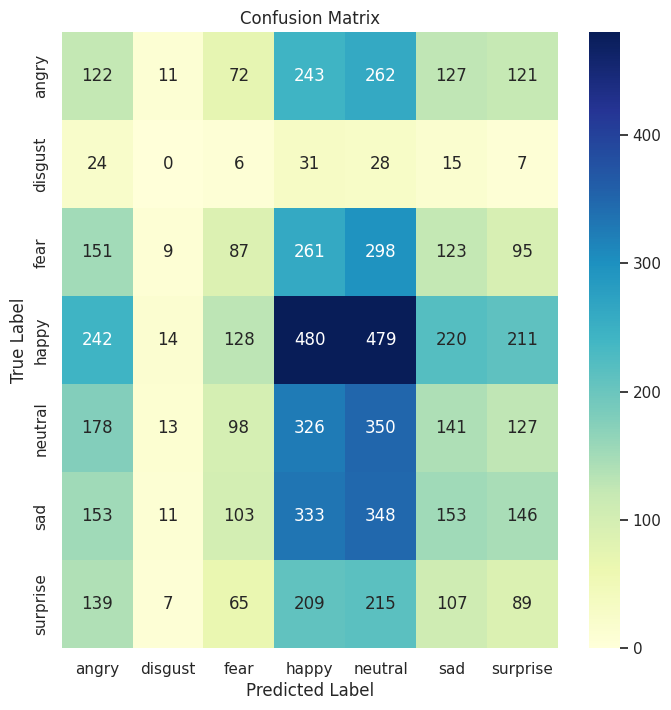

In [19]:
validation_labels = test_dataset.classes
validation_pred_probs = model.predict(test_dataset)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_dataset.class_indices.keys())
sns.set()
plt.figure(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Predicting Image

In [20]:
img = cv2.imread('/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg')
img_resize = cv2.resize(img, (48, 48))
img_processed = np.array(img_resize).reshape(-1, 48, 48,3)

In [21]:
pred = model.predict(img_processed)
pred_class = categories[np.argmax(pred)]
pred_class

1/1 [==============================] - 2s 2s/step


'happy'

In [22]:
pred

array([[2.4539374e-02, 4.1152697e-04, 8.0404282e-03, 7.8254735e-01,
        1.2555252e-01, 5.6903314e-02, 2.0055030e-03]], dtype=float32)

# Saving model

In [23]:
model.save('/kaggle/working/model')

In [24]:
!zip -r file.zip /kaggle/working/model

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/assets/ (stored 0%)
  adding: kaggle/working/model/fingerprint.pb (stored 0%)
  adding: kaggle/working/model/keras_metadata.pb (deflated 96%)
  adding: kaggle/working/model/variables/ (stored 0%)
  adding: kaggle/working/model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: kaggle/working/model/variables/variables.index (deflated 80%)
  adding: kaggle/working/model/saved_model.pb (deflated 92%)
